# RFM Analysis

In [48]:
# importing the libraries and the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
sns.set_palette("Blues")

In [2]:
# checking the current working directory
current_directory = os.getcwd()
print(current_directory)
two_directories_back = os.path.abspath(os.path.join(current_directory, "../.."))

D:\Classes\Capstone Project\Supply-Chain-Modeling-and-Analysis\src\RFM Analysis


In [3]:
# changing the working directory
os.chdir(two_directories_back)
current_directory = os.getcwd()
print(current_directory)

D:\Classes\Capstone Project\Supply-Chain-Modeling-and-Analysis


In [4]:
# reading the dataset
data = pd.read_csv("data/DataCoSupplyChainDataset.csv", encoding='latin-1')

In [5]:
# creating dataset for RFM analysis
RFM_data = data[["Customer Id","order date (DateOrders)", "Order Id", "Order Item Total"]]

In [6]:
# converting the object to datetime format
RFM_data["order date (DateOrders)"] = pd.to_datetime(data["order date (DateOrders)"])

C:\Users\imnik\AppData\Local\Temp\ipykernel_18156\981825599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_data["order date (DateOrders)"] = pd.to_datetime(data["order date (DateOrders)"])


In [7]:
# maximum datetime in the dataset
latest_date = max(pd.to_datetime(data["order date (DateOrders)"]))
print(latest_date)

2018-01-31 23:38:00


In [8]:
# aggregating the values to create vectors for clustering
RFM_data_agg = RFM_data.groupby("Customer Id").agg({
                                                    "order date (DateOrders)":["max"], 
                                                    "Order Id":["count"], 
                                                    "Order Item Total":["sum"]
                                                   })

In [9]:
# difference between the last purchase and the current date (latest date in the dataset)
RFM_data_agg["num_of_days"] = RFM_data_agg["order date (DateOrders)"].apply(lambda x: (latest_date-x))
RFM_data_agg["num_days"] = RFM_data_agg["num_of_days"].apply(lambda x: x.days)

In [10]:
# flattening the column names of the newly constructed table
RFM_data_agg.columns = ["_".join(a) for a in RFM_data_agg.columns.to_flat_index()]
RFM_data_agg

,order date (DateOrders)_max,Order Id_count,Order Item Total_sum,num_of_days_,num_days_
Customer Id,,,,,
1,2015-12-01 22:18:00,1,472.450012,792 days 01:20:00,792
2,2017-09-17 15:04:00,10,1618.660042,136 days 08:34:00,136
3,2017-06-16 01:22:00,18,3189.200037,229 days 22:16:00,229
4,2017-01-16 18:13:00,14,1480.709993,380 days 05:25:00,380
5,2016-10-31 00:38:00,7,1101.919998,457 days 23:00:00,457
...,...,...,...,...,...
20753,2018-01-31 22:14:00,1,161.869995,0 days 01:24:00,0
20754,2018-01-31 22:35:00,1,172.660004,0 days 01:03:00,0
20755,2018-01-31 22:56:00,1,314.640015,0 days 00:42:00,0


In [11]:
# normalizing the data
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data using the StandardScaler
normalized_data = scaler.fit_transform(RFM_data_agg[["Order Id_count","Order Item Total_sum","num_days_"]])

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=["item_count", "item_amount", "num_days"])

# Print the normalized data
print(normalized_df)

       item_count  item_amount  num_days
0       -0.924221    -0.747883  2.868294
1        0.150317     0.012011 -0.421731
2        1.105462     1.053220  0.044690
3        0.627889    -0.079444  0.801998
4       -0.207863    -0.330568  1.188175
...           ...          ...       ...
20647   -0.924221    -0.953786 -1.103809
20648   -0.924221    -0.946632 -1.103809
20649   -0.924221    -0.852505 -1.103809
20650   -0.924221    -1.053866 -1.103809
20651   -0.924221    -1.037909 -1.103809

[20652 rows x 3 columns]


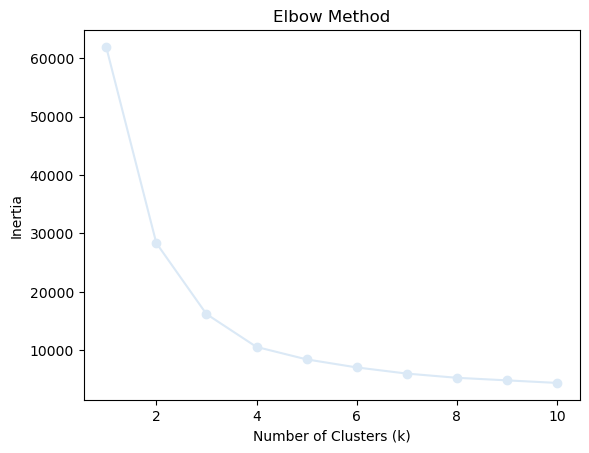

In [14]:
# k means clustering with different number of clusters using elbow method
k_values = range(1, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_df)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [52]:
# defining k-means model
def k_means_model(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    return kmeans

# defining agglomerative clustering
def agglomerative_model(n_clusters, linkage, data):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(data)
    return clustering

# defining DBSCAN clustering
def DBSCAN_model(eps, min_samples, data):
    DBSCAN_cluster = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    return DBSCAN_cluster 

In [34]:
# k-Means clustering with 5 clusters 
clustering_data = normalized_df.values
kmeans = k_means_model(5, clustering_data)

In [39]:
# agglomerative clustering with 5 clusters
clustering_data = normalized_df.values
agg_clusters = agglomerative_model(5, 'ward', clustering_data)

In [59]:
# agglomerative clustering with 5 clusters
clustering_data = normalized_df.values
dbscan_clusters = DBSCAN_model(0.2, 3, clustering_data)

In [54]:
# creating dataframe to add the clusters
RFM_date_agg_clusters = RFM_data_agg[['Order Id_count', 'Order Item Total_sum','num_days_']]

In [60]:
# adding indentified clusters to the dataframe
def adding_clusters(RFM_date_agg_clusters, model_type, model):
    RFM_date_agg_clusters[model_type] = model.labels_
    return RFM_date_agg_clusters

# adding k-means cluster data
RFM_date_agg_clusters = adding_clusters(RFM_date_agg_clusters, 'kmeans', kmeans)
RFM_date_agg_clusters = adding_clusters(RFM_date_agg_clusters, 'agg_clusters', agg_clusters)
RFM_date_agg_clusters = adding_clusters(RFM_date_agg_clusters, 'dbscan_clusters', dbscan_clusters)

In [62]:
# plotting the clusters
fig = px.scatter_3d(RFM_date_agg_clusters, 
                    x='Order Id_count', 
                    y='Order Item Total_sum', 
                    z='num_days_',
                    color='kmeans')
fig.update_traces(marker_size = 2)
fig.show()